Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](http://contrib.scikit-learn.org/categorical-encoding/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](http://contrib.scikit-learn.org/categorical-encoding/catboost.html)
- [James-Stein Encoder](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)
- [Leave One Out](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html)
- [M-estimate](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)
- [Target Encoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [Weight of Evidence](http://contrib.scikit-learn.org/categorical-encoding/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

For this reason, mean encoding won't work well within pipelines for multi-class classification problems.

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/learn/embeddings)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categoricals. It’s an active area of research and experimentation! Maybe you can make your own contributions!**_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from  scipy.stats import mode


train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [32]:
# pulling out the status_group
y = train['status_group']
x = train.drop('status_group', axis=1)
train.shape, y.shape

((59400, 41), (59400,))

In [33]:
# Splitting the train into the val and the train 
# Train will be .80 and val will be .20
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=.8, test_size=.2, random_state=42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [76]:
# checking if there are any null in the construction year and 
# the dateRecorde
df[['construction_year', 'date_recorded']].isnull().sum()

construction_year    0
date_recorded        0
dtype: int64

In [0]:

# Creating the list of the columns that I want to drop here and
# then will pass them into the wrangle function
target = 'status_group'
# This is a list of some of the colums that I want to drop
# Will drop subvillage -- because similar results as lat and lon
# Dropping funder:  has high cardinality
# Dropping the wpt_name:  has high cardinality is the name of the water point
# Dropping payment_type:  same as payment(duplicate)
cols_to_drop = ['id', 'quantity_group', 'recorded_by', "subvillage", 
                'num_private', 'funder', 'wpt_name' ,'scheme_name', 'payment_type',
                'quality_group', ]


In [0]:
# These are some inner functions in my wrangle function that help
# With the fixing the latitude and the longitude
def myLatitude(theRow,df):
  
  if pd.isnull(theRow['latitude']):
    theWard = theRow['ward']
    lat = df[df['ward'] == theWard]
    theMode = mode(lat['latitude'])
    return (theMode[0][0])
  return (theRow['latitude'])

def myLon(theRow, df): 
  if (pd.isnull(theRow['longitude'])):
    lon = df[df['ward'] == theRow['ward']]
    theMode = mode(lon['longitude'])
    return (theMode[0][0])
  return (theRow['longitude'])

In [0]:
# This is my wrangle function

def wrangleFxn(df, cols_to_drop ,numCardinal=50, useMode=True, num=None, highVar=None, lowVar=None, useDropList=True ):
  ''' This is the wrangle function
      It will take in a dataFrame either the train, test, or validate.
      It should have the TARGET already removed from it. 

      cols_to_drop:   List of features that you want to drop automatically from 
                      the dataFrame
                      It will drop the columns before looking at the cardinality of the
                      columns.

      numCardinal:  default is 50. This is the threshold.  If it is less
                    than  or equal to this number it is retained in the 
                    features.
      useMode:  default is True.  This will use the apply functiontion to 
                make the lat and lon have values similar to those in 
                the ward that it is found.
      num:      default is None.  It this is set to a number, 
                it will further reduce the cardinality of the
                cardinal features to a specified number. 
      
      highVar:  Default is None. If set will drop any columns that have more 
                variance than what is set here as the threshold.  Should be
                set as a float ie(.90 or .8)
      
      lowVar:   Default is None. if set will drop any columns who have less
                variance than here.  Should be set as a float ie(.1 or .234)

      useDropList:  Default is True.  When is True will use the cols_to_drop parameter.
                    When false will not use the cols_to_drop parameter 

      returns:  Will return the datframe prepared for the pipeline.

  '''
  
  
  target = 'status_group'
  # making the copy
  df = df.copy()
  # will try to drop the target if it is present
  if target in df.columns:
    df = df.drop(columns=[target])
  
  # Will be setting the long and lat before doing any dropping
  df['latitude'] = df['latitude'].replace(-2e-08, 0)

  # Getting rid of the zeros in the latitude and the longitude putting in 
  # np.nan
  cols_w_zeros = ['latitude', 'longitude']

  for col in cols_w_zeros:
    df[col] = df[col].replace(0, np.nan)

  if useMode == True:
    #This is to make the latitude and the longitude have
    # numbers similar to those whose region they are in
    df['latitude'] = df.apply(myLatitude, axis=1, args=(df,))
    df['longitude'] = df.apply(myLon, axis=1, args=(df,))
    pd.to_numeric(df['latitude'])
  
  # Changing the format to dateTime format and then
  # making 
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  df['construction_year'] = pd.to_datetime(df['construction_year'])
  df['construction_year'] = df['construction_year'].dt.year

  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  # Making a new feature that will be "year_age"
  df['year_age']  = df['year_recorded'] - df['construction_year']
  
  # Dropping the columns preset to drop
  if useDropList == True:
    df = df.drop(columns= cols_to_drop)

  # Getting a list of the cardinal features at the start
  cardinals = df.select_dtypes(exclude='number')

  # This to drop features that are left that have high skew (almost no variance)
  # or possibly too much variance
  if highVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0]  > highVar:
        df = df.drop(columns=[col])
  
  if lowVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0] < lowVar:
        df = df.drop(columns=[col])


  # Getting the number of features that are numerical
  numerical_features = df.select_dtypes(include='number').columns.tolist()

  # Getting the amounts in each feature of the cardinal features
  cardinalFeatureAmounts = df.select_dtypes(exclude='number')
  cardinalFeatureAmounts = cardinalFeatureAmounts.nunique()
  # checking to see if 'ward' is in the list

  # Creating a list of the features that have less than 50 cardinality
  cardinal = cardinalFeatureAmounts[cardinalFeatureAmounts <= numCardinal].index.tolist()
  
  if num != None:
    #This is to reduce the number of features in the cardinal groups
    for feature in cardinal:
      # getting the top specified amount
      topNum = df[feature].value_counts().index[:num-1].tolist()
      # replace those that are not in there with 'other'
      df.loc[~df[feature].isin(topNum), feature] = 'Other'

  # List of all the features
  features = numerical_features + cardinal

  
  

  return df[features]

In [0]:
# Trying the wrangle function  

x_train1 = wrangleFxn(x_train, cols_to_drop=cols_to_drop, num=None, highVar=.90, lowVar=.06, useDropList=True)
x_val1 = wrangleFxn(x_val, cols_to_drop=cols_to_drop, num=None, highVar=.90, lowVar=.06, useDropList=True)
x_test1 = wrangleFxn(test, cols_to_drop=cols_to_drop, num=None, highVar=.90, lowVar=.06, useDropList=True)

In [84]:
x_train1.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'year_recorded',
       'month_recorded', 'day_recorded', 'year_age', 'basin', 'region',
       'public_meeting', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [0]:
# Doing some imports for sklearn
from  sklearn.metrics import accuracy_score
from  sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce 


In [85]:
# Creating the pipeline
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, max_depth=None, 
                           min_samples_leaf=5, n_jobs=2, random_state=42)
)

pipeline = pipeline.fit(x_train1, y_train)


CPU times: user 10.8 s, sys: 57.2 ms, total: 10.9 s
Wall time: 5.78 s


In [0]:
# 2  changed min_samplesLeaf=4 -- submitted # 2
# 3  min_samplesLeaf=10
# 4  min_samplesLeaf=6
# 5  min_samplesLeaf=5
# 5 min_samplesLeaf=4, 
# 6 min_samplesLeaf=4, Automatically drop some features
# 7 same as above
# 8 min_samplesLeaf=4, Dropped columns automatically and got new feature of 
    # age of well at the time of the recoreding the info

In [0]:
# Making a list of tuples that has some iterations and the of the pipeline
pipelineList = []

In [86]:
# checking the accuracy
valScore = pipeline.score(x_val1, y_val)
trainScore = pipeline.score(x_train1, y_train)
print(f"The train shape {x_train1.shape}")
print(f"The accuracy for train is {trainScore}")
print(f"The accuracy for the validation is {valScore}")

# Putting each different pipeline model into the list
pipelineList.append((pipeline, x_test1, trainScore, valScore))

The train shape (47520, 30)
The accuracy for train is 0.8556186868686869
The accuracy for the validation is 0.8026094276094277


In [0]:
def bestScore(thePipeList):
  theScore = 0
  pipeNum = 0
  for i in range(len(thePipeList)):
    if thePipeList[i][3] > theScore:
      theScore = thePipeList[i][3]
      pipeNum = i +1
  return pipeNum , thePipeList[pipeNum -1][0], thePipeList[pipeNum -1][1]


In [88]:
len(pipelineList)

8

In [98]:
# Using the method above to pull out the best score and model

number , pipe , the_x_test = bestScore(pipelineList)

print(f"The best pipe was {number}")

The best pipe was 2


In [93]:
# printing the score of the best pipe(model)
print(f"The train score is {pipelineList[number-1][2]}")
print(f"The val score is {pipelineList[number-1][3]}")

The train score is 0.8722643097643098
The val score is 0.8081649831649832


In [0]:
# Will submitt for # 2 while I try some more

y_pred = pipe.predict(the_x_test)

In [0]:
# Kaggle submission

sumbitCopy = sample_submission.copy()
sumbitCopy['status_group'] = y_pred
sumbitCopy.to_csv(f"submit{number}.csv", index=False)


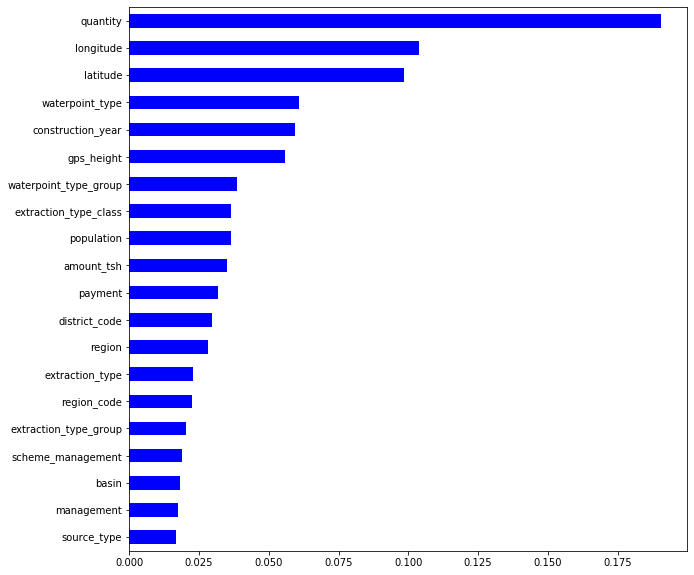

In [111]:
# doing the feature importance
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipe.named_steps['ordinalencoder']
randForrest = pipe.named_steps['randomforestclassifier']

theCols = encoder.feature_names
importances = randForrest.feature_importances_

s = pd.Series(importances, theCols)
n=20
plt.figure(figsize=(10, n/2))
s.sort_values()[-n:].plot.barh(color='blue')